In [1]:
#import functions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

from scipy import stats

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing 




/Users/dgoldstein24/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#connect sqlite3 to the Northwind Database
connection = sqlite3.connect('Northwind_small.sqlite')

In [3]:
#Attach cursor to connection in order to execute SQL commands
cursor = connection.cursor()

In [4]:
#Execute SQL command to obtain list of table names
table_names = cursor.execute('''SELECT name FROM sqlite_master WHERE type = 'table';''').fetchall()
table_names

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',),
 ('customers',)]

In [6]:
#Execute SQL command to obtain number of OrderIDs
order_ids = list((cursor.execute('''SELECT OrderID FROM OrderDetail;''').fetchall()))
len(order_ids)

2155

In [7]:
#Execute SQL command to obtain number of unique OrderIDs
unique_orders = set((cursor.execute('''SELECT OrderID FROM OrderDetail;''').fetchall()))
len(unique_orders)

830

In [8]:
#Execute SQL command to obtain OrderID table information
order_details = cursor.execute('''SELECT * FROM OrderDetail;''').fetchall()

#Convert query into Pandas DataFrame
details_df = pd.DataFrame(order_details, columns = ['x','OrderID', 'ProductID', 'UnitPrice', 'Quantity', 'Discount'])
details_df.head()

,x,OrderID,ProductID,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [9]:
#drop irrelevant columns
details_df = details_df.drop(['x'], axis = 1)

In [10]:
details_df.head()

,OrderID,ProductID,UnitPrice,Quantity,Discount
0,10248,11,14.0,12,0.0
1,10248,42,9.8,10,0.0
2,10248,72,34.8,5,0.0
3,10249,14,18.6,9,0.0
4,10249,51,42.4,40,0.0


In [11]:
# Look at discount counts
details_df['Discount'].value_counts() 

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [12]:
#create new DataFrame in which the quanitity for Order_ID is totaled
# I am defining quantity as total amount of goods purchased in an order
quantity = details_df.groupby(details_df['OrderID'], as_index = False).sum()

#create new DataFrame with same grouping as quantity but maintaining the discount amount per order
discount = details_df.groupby(details_df['OrderID'], as_index = False).max()

#create a a DataFrame with the total quantity of items and discount for each order
df_1 = discount.copy()
df_1['Quantity'] = quantity['Quantity']
df_1 = df_1.drop(['ProductID', 'UnitPrice'], axis = 1)
df_1.head()

,OrderID,Quantity,Discount
0,10248,27,0.00
1,10249,49,0.00
2,10250,60,0.15
3,10251,41,0.05
4,10252,105,0.05


null hypothesis: there is no significant difference between order quantity with or without a discount. In other words, the mean difference between the discount and non-discount group is zero

alternative hypothesis: a discount significantly affects the quantity of items purchased in an order

this test is two-tailed: although a negative relationship is unlikely, the question asks for an overall effect made by disount, not just an increase

# Do discounts have a statistically significant effect on the number of proudcts customers order?

In [13]:
#create two sample distributions: one with a discount and one without

In [14]:
without_discount = df_1[df_1['Discount'] == 0]
with_discount = df_1[df_1['Discount'] != 0]

In [15]:
with_discount.head()

,OrderID,Quantity,Discount
2,10250,60,0.15
3,10251,41,0.05
4,10252,105,0.05
6,10254,57,0.15
10,10258,121,0.20


In [16]:
without_discount.head()

,OrderID,Quantity,Discount
0,10248,27,0.0
1,10249,49,0.0
5,10253,102,0.0
7,10255,110,0.0
8,10256,27,0.0


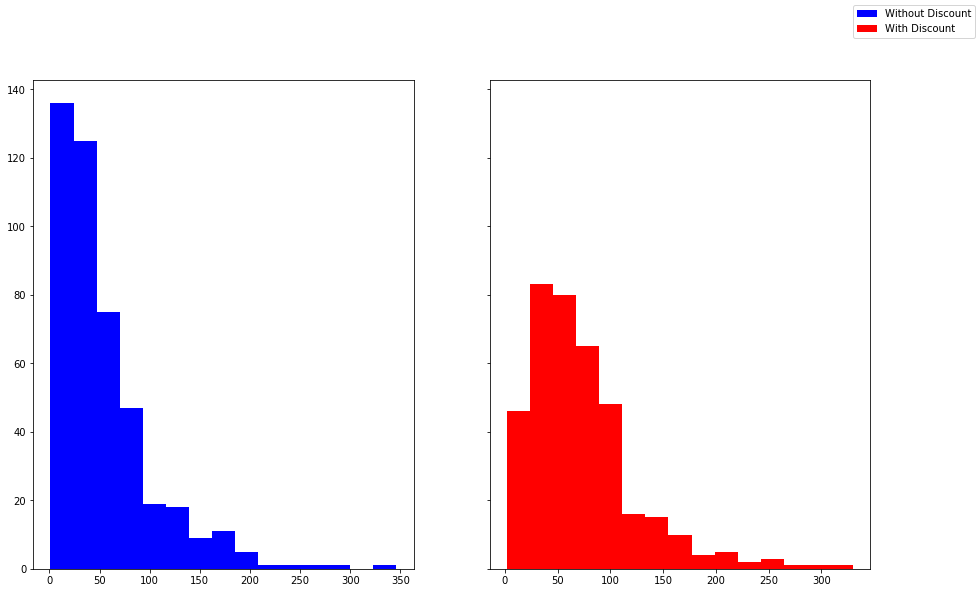

In [17]:
#Plot distributions
fig, (ax1, ax2) = plt.subplots(figsize = (15,9), sharey = True, nrows = 1, ncols = 2)
#Plot without discount distribution
ax1.hist(without_discount['Quantity'], color = 'blue', label = 'Without Discount', bins = 15)
#Plot with discount distribution
ax2.hist(with_discount['Quantity'], color = 'red', label = 'With Discount', bins = 15)
fig.legend()

In [18]:
#Calculate mean of sample without discount
without_mean = without_discount['Quantity'].mean()
without_mean

52.44

In [19]:
#Calculate mean of sample with discount
with_mean = with_discount['Quantity'].mean()
with_mean

72.94473684210526

In [20]:
#Calculate length of sample without discount
len(with_discount)

380

In [21]:
#Calculate length of sample with discount
len(without_discount)

450

In [22]:
#Not normal, different sample sizes -> should not use student T-Test
#Need to use more general Welch's t-test

In [23]:
#Find T statistic and pvalue using scipy.stats
stats.ttest_ind(with_discount['Quantity'], without_discount['Quantity'], equal_var = False)

Ttest_indResult(statistic=5.886184782446325, pvalue=5.850677815891118e-09)

### pvalue < .05, so the result is statistically significant

### The next step is to test for effect size

In [24]:
#Test for effect size using Cohen'd d that measures effect size of samples with differing means
def cohend(sample_1, sample_2):
    n1 = len(sample_1)
    n2 = len(sample_2)
    s1 = np.var(sample_1, ddof = 1)
    s2 = np.var(sample_2, ddof = 1)
    u1 = sample_1.mean()
    u2 = sample_2.mean()
    pooled_standard_deviation = np.sqrt((((n1-1)*s1)+((n2-1)*s2))/(n1+n2-2)) #weighted std for the two samples together
    cd = (u1-u2) / pooled_standard_deviation
    return cd
    

In [25]:
#Calculate cohen_d
cohend(with_discount['Quantity'], without_discount['Quantity'])

0.41225480363635514

There is a weak/moderate positive, significant relationship between discounts and quantity

The null hypothesis should be rejected and the alternative accepted: there is a signficant difference in quantity with and without a discount

# Examine significance of discounts at different levels

In [26]:
with_discount.head()

,OrderID,Quantity,Discount
2,10250,60,0.15
3,10251,41,0.05
4,10252,105,0.05
6,10254,57,0.15
10,10258,121,0.20


In [27]:
without_discount.head()

,OrderID,Quantity,Discount
0,10248,27,0.0
1,10249,49,0.0
5,10253,102,0.0
7,10255,110,0.0
8,10256,27,0.0


In [28]:
#Check lengths of prospoective discount level DataFrames
with_discount['Discount'].value_counts()

#all have at least 70 samples

0.05    86
0.15    75
0.10    74
0.20    73
0.25    72
Name: Discount, dtype: int64

In [29]:
#Create a DataFrame for each discount level
five_p_discount = with_discount[with_discount['Discount']==.05]
ten_p_discount = with_discount[with_discount['Discount']==.1]
fifteen_p_discount = with_discount[with_discount['Discount']==.15]
twenty_p_discount = with_discount[with_discount['Discount']==.20]
twentyfive_p_discount = with_discount[with_discount['Discount']==.25]

#Create list with discount level DataFrames
discount_levels = [five_p_discount, ten_p_discount, fifteen_p_discount, twenty_p_discount, twentyfive_p_discount]

In [30]:
#calculate p_value and effect size for each discount level
for level in discount_levels:
    #calculate discount
    discount = level['Discount'].median()
    #calculate the t-statistic and p-value for the two-tailed Welch's T-test between the discount level DF and no discount DF
    t_stat, p = stats.ttest_ind(level['Quantity'], without_discount['Quantity'], equal_var = False)
    #calculate the effect size of the p_value
    cohen = cohend(level['Quantity'], without_discount['Quantity'])
    print('with a discount of ' + str(discount)+ ': the p_value is ' + str(round(p,5)) + ' with an effect size of ' + str(round(cohen,5)))

with a discount of 0.05: the p_value is 0.00199 with an effect size of 0.36458
with a discount of 0.1: the p_value is 0.00089 with an effect size of 0.41548
with a discount of 0.15: the p_value is 0.00085 with an effect size of 0.48592
with a discount of 0.2: the p_value is 0.01037 with an effect size of 0.33795
with a discount of 0.25: the p_value is 0.00069 with an effect size of 0.50471


### A 25% discount has the lowest p_value and the greatest effect size, so one can be most confident in a 25% discount increasing purchase quantity

# Test 3 Other Hypotheses: Freight, Region, and Customer Title Effects on Quantity Sold

## Create DataFrame with Quantity, Freight, Region, and Customer Title

In [31]:
df_1.head()

,OrderID,Quantity,Discount
0,10248,27,0.00
1,10249,49,0.00
2,10250,60,0.15
3,10251,41,0.05
4,10252,105,0.05


In [32]:
#Query SQL to get Orders
orders = cursor.execute('''SELECT ID, CustomerID, Freight FROM "Order"''').fetchall()
#Convert Orders to DataFrame
orders_df = pd.DataFrame(orders, columns = ['OrderID', 'CustomerID', 'Freight'])

In [33]:
orders_df.head()

,OrderID,CustomerID,Freight
0,10248,VINET,32.38
1,10249,TOMSP,11.61
2,10250,HANAR,65.83
3,10251,VICTE,41.34
4,10252,SUPRD,51.30


In [34]:
#Query SQL to get Customers
customers = cursor.execute('''SELECT * FROM "Customer"''').fetchall()
#Convert Customers to DataFrame
customers_df = pd.DataFrame(customers, columns = ["Code","CompanyName", "ContactName", "ContactTitle", "Address", "City", "Region","PostalCode", "Country", "Phone", "Fax"])

In [35]:
#Check customers_df for unnecessary columns
customers_df.head()

,Code,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67


In [36]:
#Drop unnecessary columns from customers_df
to_drop = ["CompanyName", "ContactName", "Address", "City","PostalCode", "Country", "Phone", "Fax"]
customers_df = customers_df.drop(to_drop, axis =1)

In [37]:
#Check values for Customers - note: some customers place multiple orders, so there length of this DataFrame will be shorter than others
customers_df['ContactTitle'].value_counts()

Sales Representative              17
Owner                             17
Marketing Manager                 12
Sales Manager                     11
Accounting Manager                10
Sales Associate                    7
Marketing Assistant                6
Sales Agent                        5
Order Administrator                2
Assistant Sales Agent              2
Owner/Marketing Assistant          1
Assistant Sales Representative     1
Name: ContactTitle, dtype: int64

In [38]:
#Drop OrderID column from orders_df so that there is not a repeat column with later concatenation with df_1
orders_df = orders_df.drop(['OrderID'], axis = 1)

In [39]:
#Concatenate orders_df and df_2 in order to OrderID, Customer, ID, Freight and Quantity in the same DataFrame
df_2 = pd.concat([orders_df, df_1], axis = 1)
df_2.head()

,CustomerID,Freight,OrderID,Quantity,Discount
0,VINET,32.38,10248,27,0.00
1,TOMSP,11.61,10249,49,0.00
2,HANAR,65.83,10250,60,0.15
3,VICTE,41.34,10251,41,0.05
4,SUPRD,51.30,10252,105,0.05


In [40]:
#additional variables beyond freight compare with quantity are Title and Region - process to add it to df_2 is below

In [41]:
#customers_df has title and region for each customer code
customers_df.head()

,Code,ContactTitle,Region
0,ALFKI,Sales Representative,Western Europe
1,ANATR,Owner,Central America
2,ANTON,Owner,Central America
3,AROUT,Sales Representative,British Isles
4,BERGS,Order Administrator,Northern Europe


In [57]:
#Add customers_df to SQL in order to more easily extract regions and titles
#customers_df.to_sql('customers', con = connection) - already done

In [43]:
#Test sql query
cursor.execute('''SELECT Region FROM customers WHERE Code = 'VINET';''').fetchall()

[('Western Europe',)]

In [44]:
#Create lists that will be turned into columns in df_2
corresponding_regions = []
corresponding_title = []

#Create loop to fill lists
for i in range(len(df_2)):
    
    #format each customer code to work with SQL command syntax
    code = "'" + str(df_2.iloc[i][0]) + "'"
    
    #add customer code to commands to fetch region
    region_command = 'SELECT Region FROM customers WHERE Code = ' + code
    
    #add customer code to commands to fetch title
    title_command = 'SELECT ContactTitle FROM customers WHERE Code = ' + code
    
    #execute command to fetch region
    region = cursor.execute(region_command).fetchall()
    
    #execute command to fetch region
    title =  cursor.execute(title_command).fetchall()
    
    #add region and title to corresponding list
    corresponding_regions.append(region)
    corresponding_title.append(title)

#add regions and titles as coulumns in df_2
df_2['Region'] = corresponding_regions
df_2['Title'] = corresponding_title

In [45]:
#Check df_2
df_2.head()

,CustomerID,Freight,OrderID,Quantity,Discount,Region,Title
0,VINET,32.38,10248,27,0.00,"[(Western Europe,)]","[(Accounting Manager,)]"
1,TOMSP,11.61,10249,49,0.00,"[(Western Europe,)]","[(Marketing Manager,)]"
2,HANAR,65.83,10250,60,0.15,"[(South America,)]","[(Accounting Manager,)]"
3,VICTE,41.34,10251,41,0.05,"[(Western Europe,)]","[(Sales Agent,)]"
4,SUPRD,51.30,10252,105,0.05,"[(Western Europe,)]","[(Accounting Manager,)]"


In [46]:
#need to get rid of characters at beginnning and end of both region and title entries

In [47]:
#create lists to be filled with corrected entries for region and title respectively
edited_region = []
edited_title = []

#edit each region entry and add to edited_region list
for reg in list(df_2['Region']):
    reg = str(reg)[3:-4]
    edited_region.append(reg)

#edit each title entry and add to edited_title list
for titl in list(df_2['Title']):
    titl = str(titl)[3:-4]
    edited_title.append(titl)

#Replace Region and Title columns with edited entries
df_2_edited = df_2.drop(['Region', 'Title'], axis = 1)
df_2_edited['Region'] = edited_region
df_2_edited['Title'] = edited_title

In [48]:
#Check DataFrame
df_2_edited.head()

,CustomerID,Freight,OrderID,Quantity,Discount,Region,Title
0,VINET,32.38,10248,27,0.00,Western Europe,Accounting Manager
1,TOMSP,11.61,10249,49,0.00,Western Europe,Marketing Manager
2,HANAR,65.83,10250,60,0.15,South America,Accounting Manager
3,VICTE,41.34,10251,41,0.05,Western Europe,Sales Agent
4,SUPRD,51.30,10252,105,0.05,Western Europe,Accounting Manager


In [49]:
df_2_edited[df_2_edited['Freight'] > 20].count()

CustomerID    563
Freight       563
OrderID       563
Quantity      563
Discount      563
Region        563
Title         563
dtype: int64

In [50]:
df_2_edited[df_2_edited['Region'] ==  'Western Europe'].count()

CustomerID    272
Freight       272
OrderID       272
Quantity      272
Discount      272
Region        272
Title         272
dtype: int64

In [51]:
df_3 = df_2_edited

## Null Hypothesis 1: A shipping charge of 20 or more does not signficantly affect quantity of items purchased

## Alternative Hypothesis: A shipping charge of 20 or more  signficantly affects quantity of items purchased

In [62]:
#Split samples - one with 20 dollar and over shipping and another with under 20 dollar shipping
over_twenty = df_3[df_3['Freight'] >= 20]
under_twenty = df_3[df_3['Freight'] < 20]

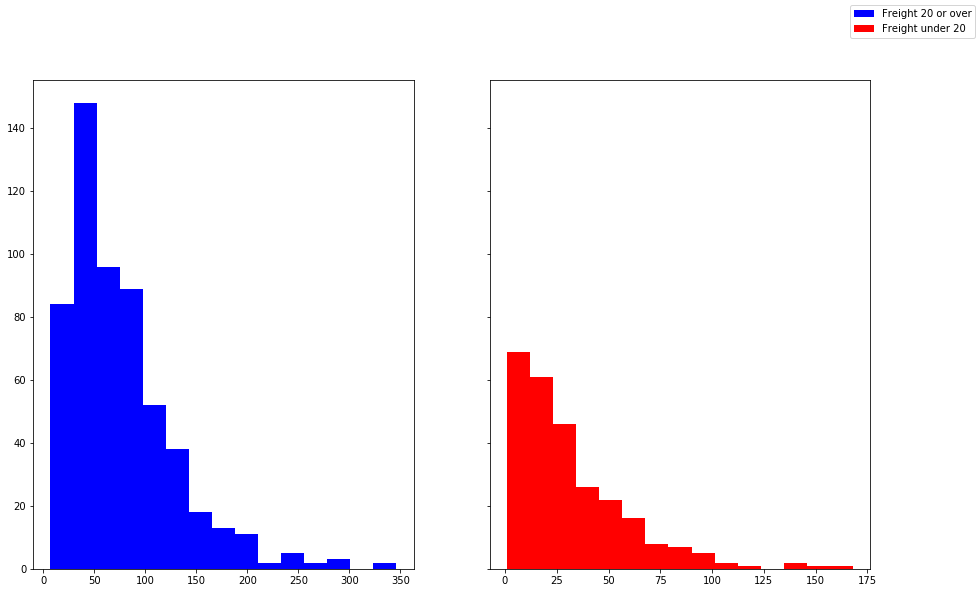

In [59]:
#Plot distributions
fig, (ax1, ax2) = plt.subplots(figsize = (15,9), sharey = True, nrows = 1, ncols = 2)
#Plot over 20 distribution
ax1.hist(over_twenty['Quantity'], color = 'blue', label = 'Freight 20 or over', bins = 15)
#Plot under 20 distribution
ax2.hist(under_twenty['Quantity'], color = 'red', label = 'Freight under 20', bins = 15)
fig.legend()

In [60]:
#Find T statistic and pvalue using scipy.stats
stats.ttest_ind(over_twenty['Quantity'], under_twenty['Quantity'], equal_var = False)

Ttest_indResult(statistic=15.532122586980316, pvalue=7.052620349637665e-48)

In [61]:
#Find Effect Size
cohend(over_twenty['Quantity'], under_twenty['Quantity'])

0.9406025330708245

Freight has a significant, strong positive effect on quantity purchased

## Null Hypothesis 2: A purchase from Western Europe does not signficantly affect quantity of items purchased

## Alternative Hypothesis: A purchase from Western Europe signficantly affects quantity of items purchased

In [63]:
df_3.head()

,CustomerID,Freight,OrderID,Quantity,Discount,Region,Title
0,VINET,32.38,10248,27,0.00,Western Europe,Accounting Manager
1,TOMSP,11.61,10249,49,0.00,Western Europe,Marketing Manager
2,HANAR,65.83,10250,60,0.15,South America,Accounting Manager
3,VICTE,41.34,10251,41,0.05,Western Europe,Sales Agent
4,SUPRD,51.30,10252,105,0.05,Western Europe,Accounting Manager


In [64]:
#Split samples - one for which the region is Wester Europe and another for all other regions
w_e = df_3[df_3['Region'] == 'Western Europe']
not_w_e = df_3[df_3['Region']  != 'Western Europe']

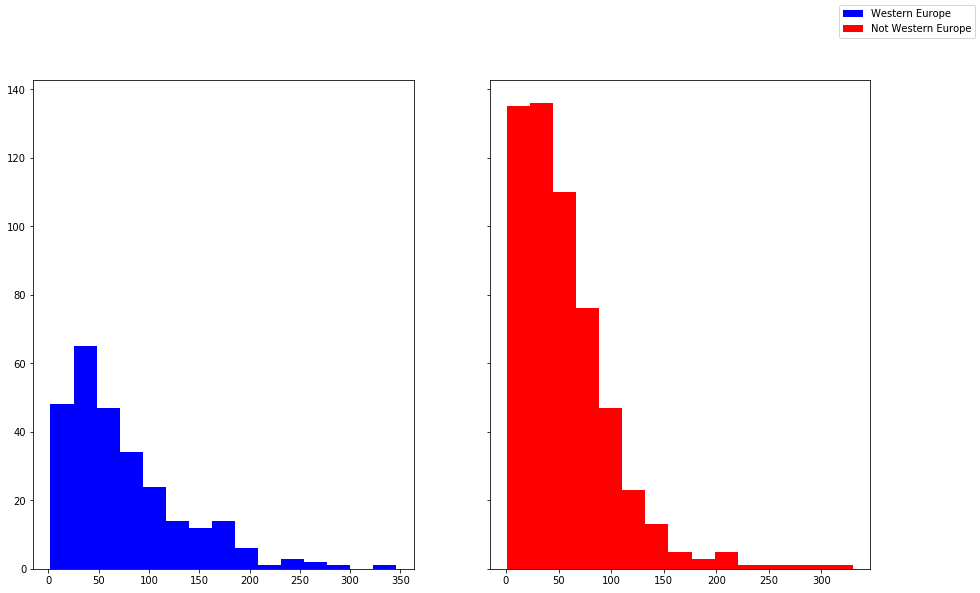

In [70]:
#Plot distributions
fig, (ax1, ax2) = plt.subplots(figsize = (15,9), sharey = True, nrows = 1, ncols = 2)
#Plot Western Europe distribution
ax1.hist(w_e['Quantity'], color = 'blue', label = 'Western Europe', bins = 15)
#Plot not Western Europ distribution
ax2.hist(not_w_e['Quantity'], color = 'red', label = 'Not Western Europe', bins = 15)
fig.legend()

In [66]:
#Find T statistic and pvalue using scipy.stats
stats.ttest_ind(w_e['Quantity'], not_w_e['Quantity'], equal_var = False)

Ttest_indResult(statistic=4.611656049888686, pvalue=5.264245347898961e-06)

In [67]:
#Find Effect Size
cohend(w_e['Quantity'], not_w_e['Quantity'])

0.3721401514895702

Weak positive significant relationship between Western Europe and quantity

## Null Hypothesis 3: Being an owner calling for the order does not signficantly affect quantity of items purchased

## Alternative Hypothesis: Being an owner calling for the order signficiantly affects quantity of  items purchased

In [69]:
df_3.Title.value_counts()

Sales Representative              160
Sales Manager                     128
Owner                             123
Accounting Manager                116
Marketing Manager                  82
Sales Associate                    65
Marketing Assistant                31
Sales Agent                        31
                                   29
Order Administrator                24
Assistant Sales Representative     18
Assistant Sales Agent              16
Owner/Marketing Assistant           7
Name: Title, dtype: int64

In [71]:
#Split samples - one for which the region is Wester Europe and another for all other regions
owner = df_3[df_3['Title'] == 'Owner']
not_owner = df_3[df_3['Title']  != 'Owner']

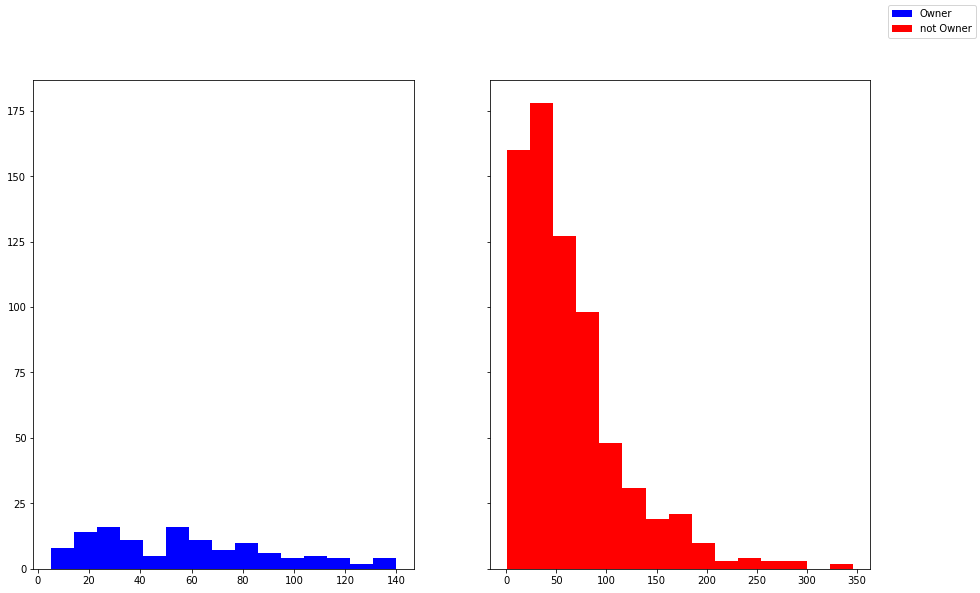

In [72]:
#Plot distributions
fig, (ax1, ax2) = plt.subplots(figsize = (15,9), sharey = True, nrows = 1, ncols = 2)
#Plot Western Europe distribution
ax1.hist(owner['Quantity'], color = 'blue', label = 'Owner', bins = 15)
#Plot not Western Europ distribution
ax2.hist(not_owner['Quantity'], color = 'red', label = 'not Owner', bins = 15)
fig.legend()

In [73]:
#Find T statistic and pvalue using scipy.stats
stats.ttest_ind(owner['Quantity'], not_owner['Quantity'], equal_var = False)

Ttest_indResult(statistic=-1.6970492705228857, pvalue=0.09100807943125604)

In [74]:
#Find Effect Size
cohend(owner['Quantity'], not_owner['Quantity'])

-0.12376307386795218

Insignificant weak negative relationship between being an owner and quantity purchased